# Carregando os dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from itertools import combinations
from collections import Counter

In [2]:
%%time
transactions_2009_2010 = pd.read_excel('../online_retail_II.xlsx',sheet_name="Year 2009-2010", engine='openpyxl')
transactions_2010_2011= pd.read_excel('../online_retail_II.xlsx',sheet_name="Year 2010-2011", engine='openpyxl')

CPU times: total: 1min 46s
Wall time: 1min 47s


In [3]:
# Concatenar os DataFrames (empilhar as linhas)
df = pd.concat([transactions_2009_2010, transactions_2010_2011], ignore_index=True)

# Exibir as primeiras linhas do DataFrame combinado
print(df.shape)

(1067371, 8)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


([<matplotlib.axis.YTick at 0x1d986c3c2b0>,
 [Text(0, 0, 'Invoice'),
  Text(0, 1, 'StockCode'),
  Text(0, 2, 'Description'),
  Text(0, 3, 'Quantity'),
  Text(0, 4, 'InvoiceDate'),
  Text(0, 5, 'Price'),
  Text(0, 6, 'Customer ID'),
  Text(0, 7, 'Country')])

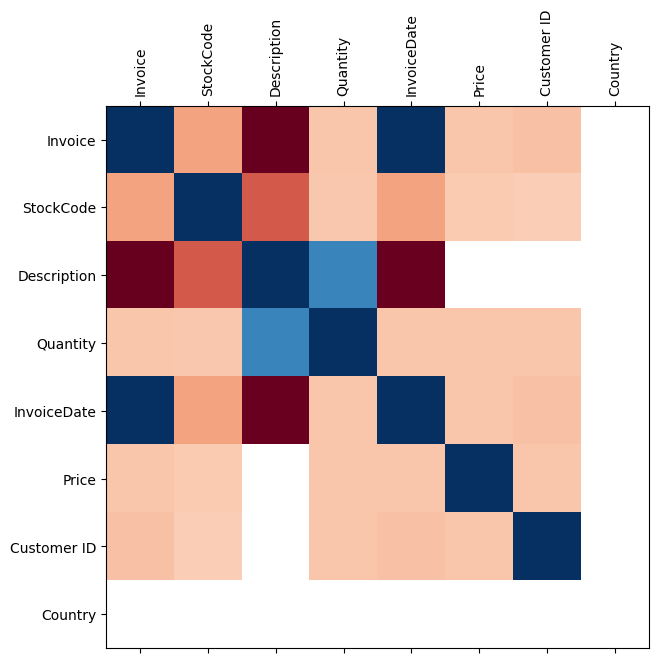

In [5]:
# Análise de correlação de dados
# Convert all columns to numeric, replacing errors with NaN
df_numeric = df.apply(pd.to_numeric, errors='coerce')
correlation = df_numeric.corr()
fig = plt.figure(figsize=(7,7))
plt.matshow(correlation, cmap='RdBu', fignum=fig.number)
plt.xticks(range(len(correlation.columns)), correlation.columns, rotation='vertical')
plt.yticks(range(len(correlation.columns)), correlation.columns)

# Limpeza de Dados

In [6]:
# Verificando valores ausentes
df.isna().sum()
print(df.loc[df['Invoice'] == 'C536379'])

# Obtêm os transações canceladas
df['Quantity'] = pd.to_numeric(df['Quantity'])
df_devolucoes = df.loc[df['Quantity'] < 0]

# print(df.loc[df['Invoice'].astype(str).str.contains('C')])

# Remove as transações canceladas
df = df[df['Quantity'] > 1]

# Verificando valores númericos
df['Invoice'] = pd.to_numeric(df['Invoice'], errors='coerce')

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['Description'] = df['Description'].astype(str)

        Invoice StockCode Description  Quantity         InvoiceDate  Price  \
503073  C536379         D    Discount        -1 2010-12-01 09:41:00   27.5   
525602  C536379         D    Discount        -1 2010-12-01 09:41:00   27.5   

        Customer ID         Country  
503073      14527.0  United Kingdom  
525602      14527.0  United Kingdom  


# Análise de Dados Básicos

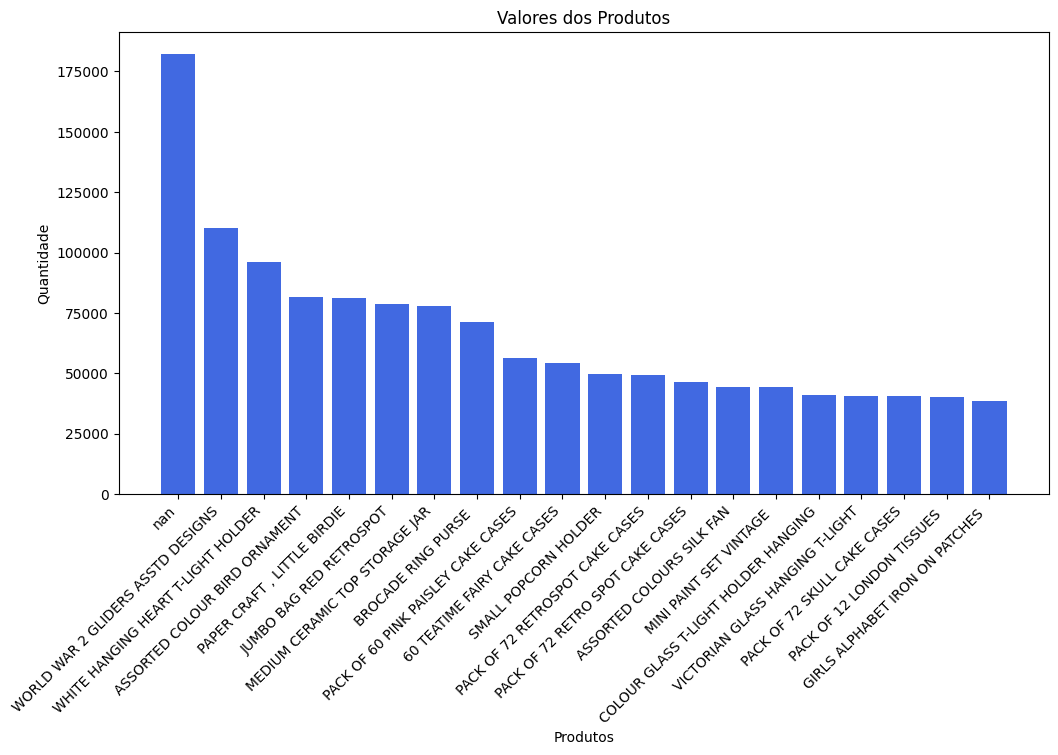

In [32]:
# Adiciona a coluna ano
df['ano'] = df['InvoiceDate'].dt.year

df['mes'] = df['InvoiceDate'].dt.month

df['dia'] = df['InvoiceDate'].dt.day

df['hora'] = df['InvoiceDate'].dt.hour

# Extrai o dia da semana (0 = segunda, 6 = domingo)
df['DiaSemana'] = df['InvoiceDate'].dt.dayofweek

df['semana_mes'] = df['InvoiceDate'].dt.isocalendar().week

# Agrupoar por produto e somar as quantidades vendidas
top_products = df.groupby('Description')['Quantity'].sum().reset_index()

# Ordenar do mais vendido para o menos vendido
top_products = top_products.sort_values(by='Quantity', ascending=False)

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(top_products['Description'].head(20), top_products['Quantity'].head(20), color='royalblue')
plt.xticks(rotation=45, ha='right')
# Adicionando rótulos e título
plt.xlabel("Produtos")
plt.ylabel("Quantidade")
plt.title("Valores dos Produtos")
# Exibindo o gráfico
plt.show()

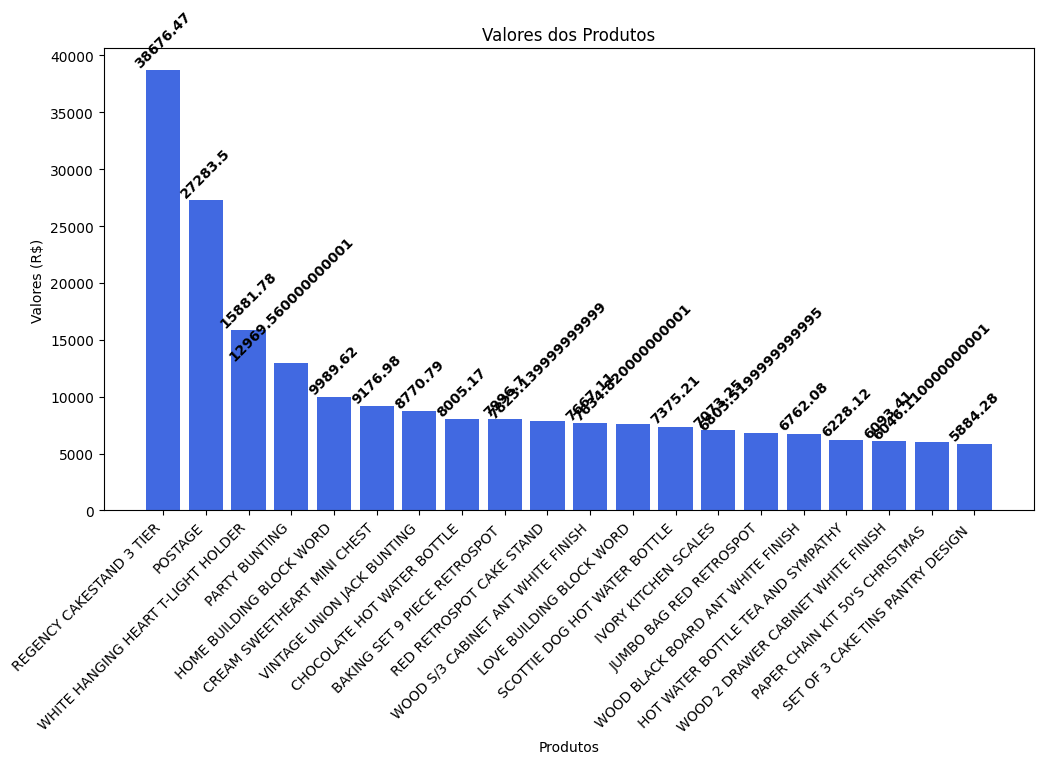

In [8]:
# Agrupoar por produto e somar as quantidades vendidas
top_products_revenue = df.groupby('Description')['Price'].sum().reset_index()

# Ordenar do mais vendido para o menos vendido
top_products_revenue = top_products_revenue.sort_values(by='Price', ascending=False)

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
barras = plt.bar(top_products_revenue['Description'].head(20), top_products_revenue['Price'].head(20), color='royalblue')
for barra in barras:
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, altura, f'{altura}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold', rotation=45)

plt.xticks(rotation=45, ha='right')
# Adicionando rótulos e título
plt.xlabel("Produtos")
plt.ylabel("Valores (R$)")
plt.title("Valores dos Produtos")
# Exibindo o gráfico
plt.show()

In [9]:
# Mostrar o total de vendas
df['Invoice'].unique().shape[0]

40057

In [10]:
# Agrupa por Invoice e soma as quantidades de cada pedido
quantidade_por_pedido = df.groupby('Invoice')['Quantity'].sum()

# Calcula a média de produtos por pedido
media_produtos_por_pedido = quantidade_por_pedido.mean()

print(f"Média de produtos por pedido: {media_produtos_por_pedido:.2f}")

Média de produtos por pedido: 284.05


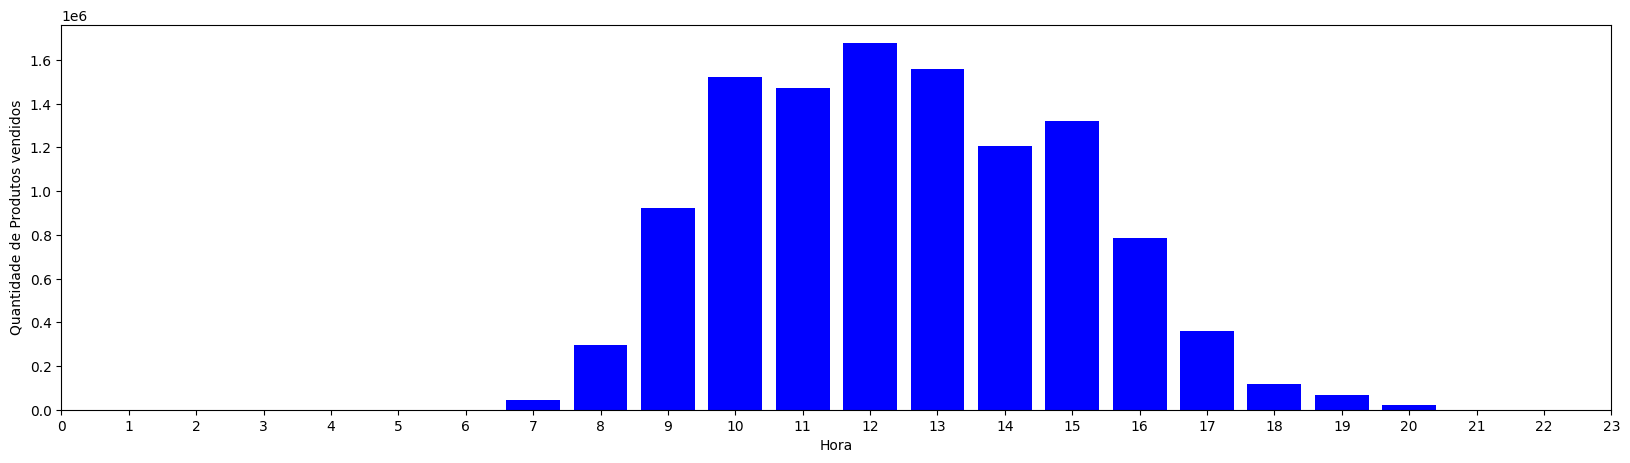

In [11]:
top_hours = df.groupby('hora')['Quantity'].sum().reset_index()

# print(top_hours.head(24))

# Qual hora do dia tem o maior número de pedidos?
plt.figure(figsize=(20,5))
plt.bar(top_hours['hora'], top_hours['Quantity'], color='blue')
plt.xticks(np.arange(0, 24, 1))
plt.xlabel('Hora')
plt.ylabel('Quantidade de Produtos vendidos')
plt.show()


# Total de vendas por tempo(diário, semanal, mensal)

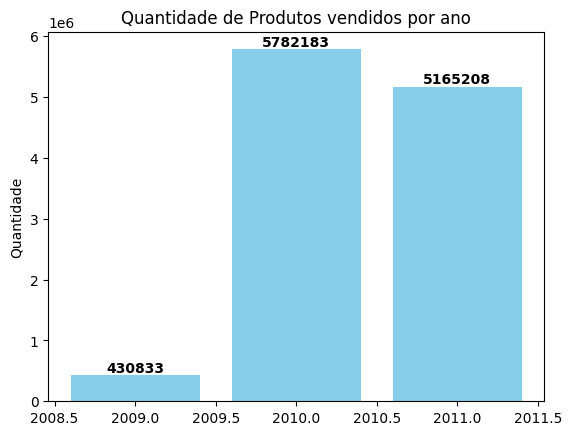

In [12]:
# Total de vendas por ano
df_by_year = df.groupby('ano', as_index=False)['Quantity'].sum()

# Criar o gráfico de barras
fig, ax = plt.subplots()
barras = ax.bar(df_by_year['ano'], df_by_year['Quantity'], color='skyblue')

# Adicionar os valores nas barras
for barra in barras:
    altura = barra.get_height()
    ax.text(barra.get_x() + barra.get_width()/2, altura, 
            f'{altura}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Configurar rótulos e título
ax.set_ylabel('Quantidade')
ax.set_title('Quantidade de Produtos vendidos por ano')

# Mostrar o gráfico
plt.show()

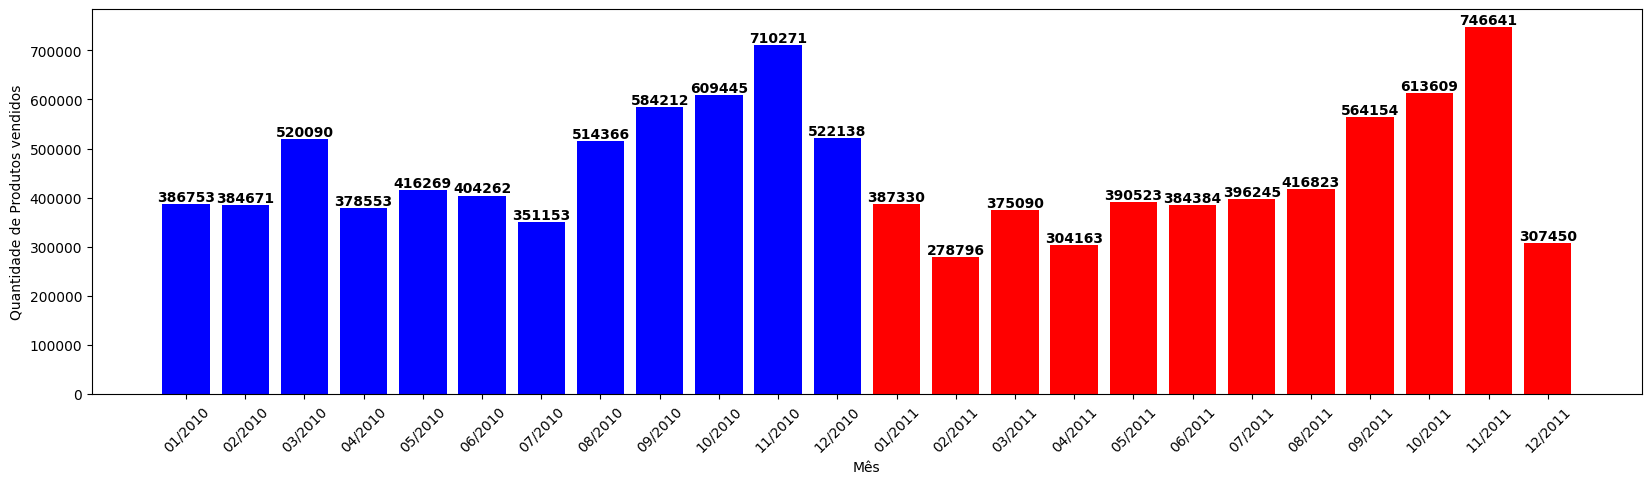

In [13]:
# Total de vendas por mês
df_by_month = df.groupby(['ano','mes'], as_index=False)['Quantity'].sum().reset_index()

df_by_month['date'] = df_by_month['mes'].astype(str).str.zfill(2) + "/" + df_by_month['ano'].astype(str)

df_by_month_2010 = df_by_month.loc[df_by_month['ano'] == 2010]

plt.figure(figsize=(20,5))
barras_2010 = plt.bar(df_by_month['date'].loc[df_by_month['ano'] == 2010], df_by_month['Quantity'].loc[df_by_month['ano'] == 2010], color='blue')
barras_2011 = plt.bar(df_by_month['date'].loc[df_by_month['ano'] == 2011], df_by_month['Quantity'].loc[df_by_month['ano'] == 2011], color='red')
for barra in barras_2010:
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, altura, 
            f'{altura}', ha='center', va='bottom', fontsize=10, fontweight='bold')
for barra in barras_2011:
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, altura, 
            f'{altura}', ha='center', va='bottom', fontsize=10, fontweight='bold')
# plt.xticks(np.arange(0, 13, 1))
plt.xlabel('Mês')
plt.xticks(rotation=45)
plt.ylabel('Quantidade de Produtos vendidos')
plt.show()

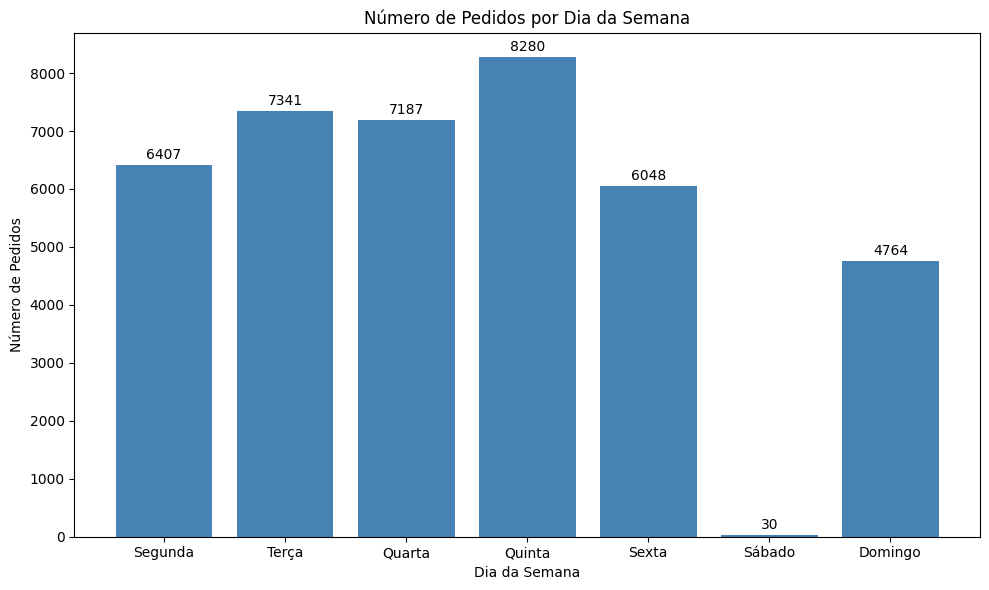

In [33]:
# Total de vendas semanal
# Mapeia o número para o nome do dia
dias_nome = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']
df['DiaSemanaNome'] = df['DiaSemana'].map(dict(enumerate(dias_nome)))

# Conta quantos pedidos únicos existem por dia
pedidos_por_dia = df.drop_duplicates(subset='Invoice').groupby('DiaSemanaNome').size()

# Ordena pela ordem dos dias da semana
pedidos_por_dia = pedidos_por_dia.reindex(dias_nome)

# Gráfico
plt.figure(figsize=(10, 6))
plt.bar(pedidos_por_dia.index, pedidos_por_dia.values, color='steelblue')
plt.title('Número de Pedidos por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Número de Pedidos')

# Adiciona os valores acima de cada barra
for i, v in enumerate(pedidos_por_dia.values):
    plt.text(i, v + 50, str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [15]:
# Transações vendidas por dia
df_by_day = df.groupby(['ano', 'mes', 'dia'], as_index=False)['Quantity'].sum()

print(df_by_day)

      ano  mes  dia  Quantity
0    2009   12    1     25412
1    2009   12    2     30728
2    2009   12    3     50143
3    2009   12    4     20544
4    2009   12    5      5110
..    ...  ...  ...       ...
599  2011   12    5     42865
600  2011   12    6     29455
601  2011   12    7     41553
602  2011   12    8     33938
603  2011   12    9     93447

[604 rows x 4 columns]


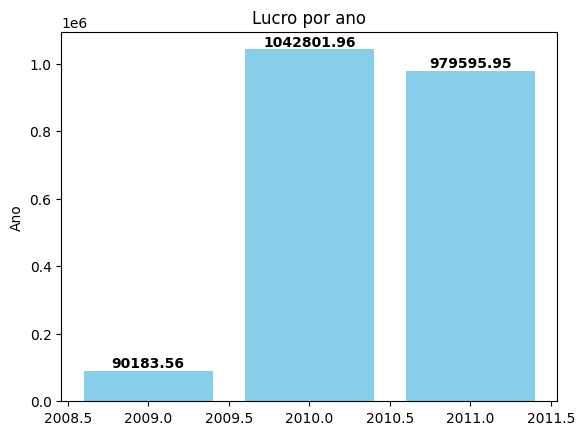

In [16]:
# Total de vendas por ano
prices_by_year = df.groupby('ano', as_index=False)['Price'].sum()

fig, ax = plt.subplots()
barras = ax.bar(prices_by_year['ano'], prices_by_year['Price'], color='skyblue')

# Adicionar os valores nas barras
for barra in barras:
    altura = barra.get_height()
    ax.text(barra.get_x() + barra.get_width()/2, altura, 
            f'{altura}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Configurar rótulos e título
ax.set_ylabel('Ano')
ax.set_title('Lucro por ano')

# Mostrar o gráfico
plt.show()

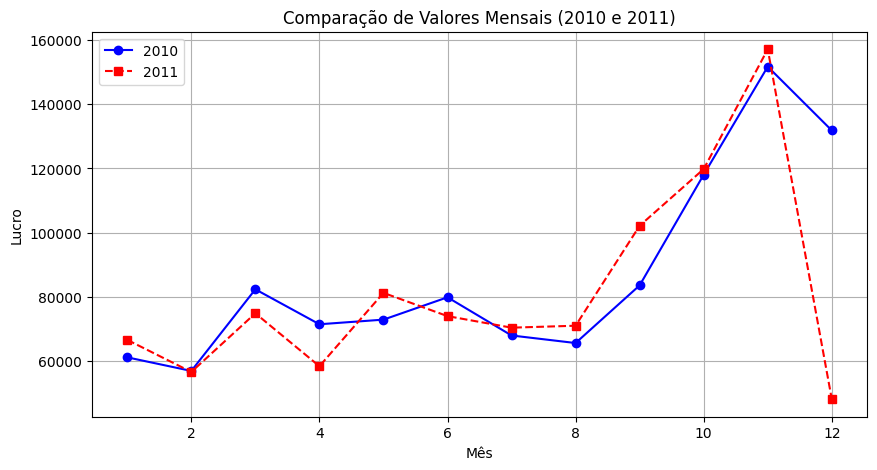

In [17]:
# Total de vendas por mês
# prices_by_month = df_filtered.groupby('mes', as_index=False)['Price'].sum()
prices_by_month = df.groupby(['ano', 'mes'], as_index=False).agg({'Price': 'sum'})

prices_by_month_filtered = prices_by_month.loc[prices_by_month['ano'] == 2011]

prices_by_month_2011 = prices_by_month[prices_by_month['ano'] == 2011]
prices_by_month_2010 = prices_by_month[prices_by_month['ano'] == 2010]

plt.figure(figsize=(10, 5))
plt.plot(prices_by_month_2010['mes'], prices_by_month_2010['Price'],  marker='o', linestyle='-', label='2010', color='blue')
plt.plot(prices_by_month_2011['mes'], prices_by_month_2011['Price'], marker='s', linestyle='--', label='2011', color='red')

plt.xlabel('Mês')
plt.ylabel('Lucro')
plt.title('Comparação de Valores Mensais (2010 e 2011)')
plt.legend()
plt.grid(True)


# Mostrar o gráfico
plt.show()

# Análise de Recorrência de Clientes

In [18]:
df_sorted = df.sort_values(by=['Customer ID', 'InvoiceDate'])

df_sorted['dias_entre_compras'] = df_sorted.groupby('Customer ID')['InvoiceDate'].diff().dt.days

media_dias_por_cliente = df_sorted.groupby('Customer ID')['dias_entre_compras'].mean().reset_index()
media_dias_por_cliente.rename(columns={'dias_entre_compras': 'media_dias_recompra'}, inplace=True)
print(media_dias_por_cliente.sort_values(by='media_dias_recompra', ascending=False))


      Customer ID  media_dias_recompra
5726      18174.0                596.0
4038      16454.0                542.0
4315      16737.0                524.0
5273      17715.0                392.0
938       13302.0                371.0
...           ...                  ...
5540      17986.0                  NaN
5621      18068.0                  NaN
5685      18133.0                  NaN
5736      18184.0                  NaN
5785      18233.0                  NaN

[5840 rows x 2 columns]


In [19]:
compras_por_cliente = df.groupby('Customer ID')['Invoice'].count().reset_index()
compras_por_cliente = compras_por_cliente.rename(columns={"Invoice": "qtd_compras"})
compras_por_cliente['tipo_cliente'] = compras_por_cliente['qtd_compras'].apply(
    lambda x: "recorrente" if x > 1 else "novo"
)
print(compras_por_cliente.sort_values(by='qtd_compras', ascending=False).head(5))

      Customer ID  qtd_compras tipo_cliente
2517      14911.0        10916   recorrente
5398      17841.0         5557   recorrente
1775      14156.0         3936   recorrente
392       12748.0         3740   recorrente
2259      14646.0         3583   recorrente


In [20]:
# Juntar os dois dataframes
df = df.merge(compras_por_cliente, on='Customer ID', how='left')
df = df.merge(media_dias_por_cliente, on='Customer ID', how='left')

In [21]:
clientes_total = df["Customer ID"].nunique()
clientes_recorrentes = df[df["tipo_cliente"] == "recorrente"]["Customer ID"].nunique()

taxa_retencao = (clientes_recorrentes / clientes_total) * 100
print(f"Taxa de Retenção: {taxa_retencao:.0f}%")

Taxa de Retenção: 98%


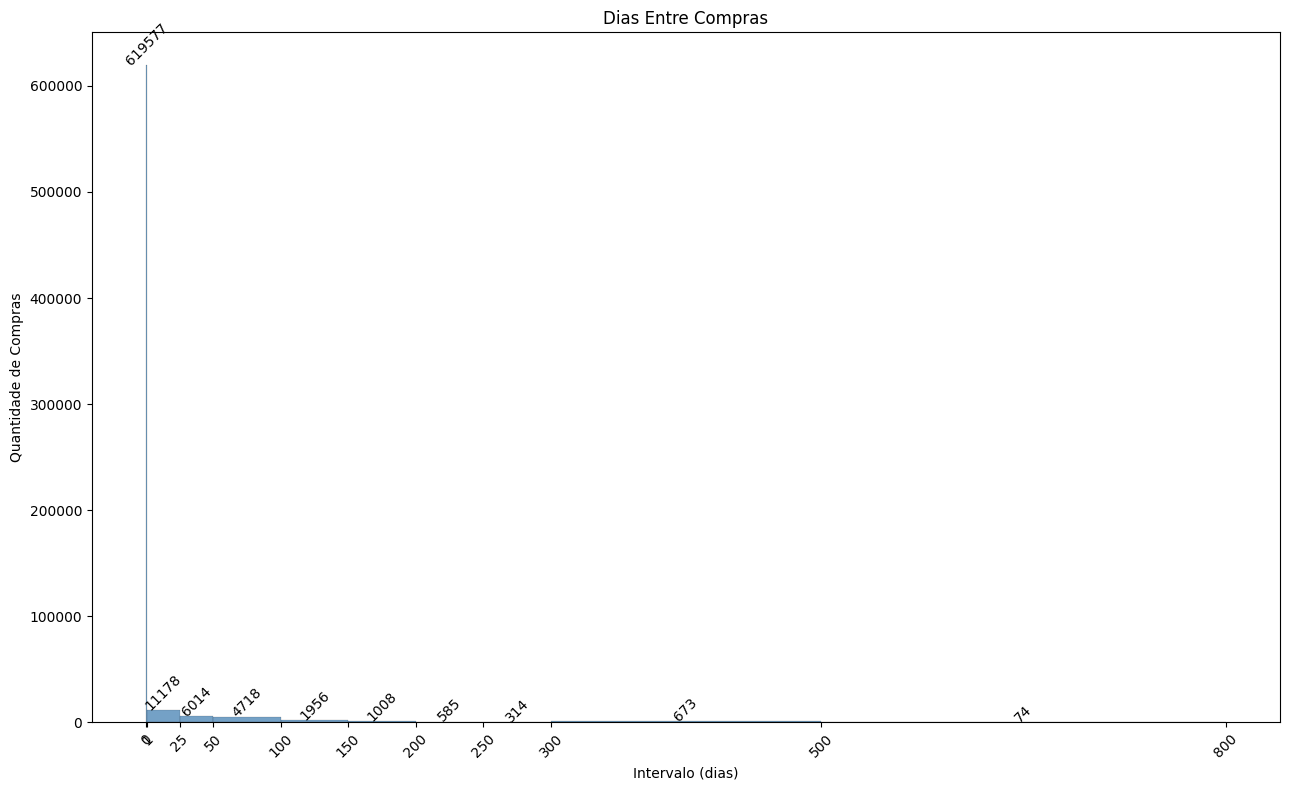

In [22]:
# Filtrar apenas clientes com mais de uma compra
dias_validos = df_sorted["dias_entre_compras"].dropna()

# print(dias_validos.sort_values(ascending=False))
plt.figure(figsize=(13, 8))

# Criar o histograma e capturar os dados do gráfico
ax = sns.histplot(dias_validos, bins=[0, 1, 25, 50, 100, 150, 200, 250, 300, 500, 800], kde=False, color='steelblue', )
# ax = sns.histplot(dias_validos, bins=[0, 1, 2, 3, 4, 5, 6], kde=False, color='steelblue')

# Adiciona os valores manualmente nas barras
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width()/2, height + 0.5, int(height), ha="center", rotation=45)

plt.title("Dias Entre Compras")
plt.xlabel("Intervalo (dias)")
plt.ylabel("Quantidade de Compras")
plt.xticks(ticks=[0, 1, 25, 50, 100, 150, 200, 250, 300, 500, 800], rotation=45)
plt.tight_layout()
plt.show()

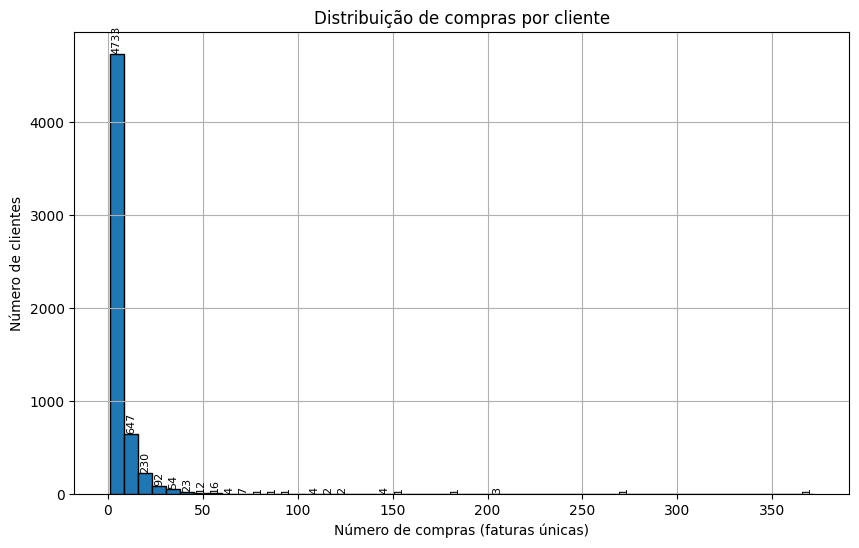

In [23]:
# Remove linhas sem Customer ID
df_clientes = df.dropna(subset=['Customer ID'])

# Conta quantas faturas (compras) cada cliente realizou
compras_por_cliente = df_clientes.groupby('Customer ID')['Invoice'].nunique()

# Exibe os top 10 clientes mais recorrentes
top_clientes = compras_por_cliente.sort_values(ascending=False).head(10)
# print("Top 10 clientes mais recorrentes:")
# print(top_clientes)

# Plota a distribuição
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(compras_por_cliente, bins=50, edgecolor='black')
# Adiciona rótulos em cima de cada barra
for count, bin_edge, patch in zip(n, bins, patches):
    if count > 0:
        plt.text(
            x=patch.get_x() + patch.get_width() / 2,  # centraliza no topo da barra
            y=count,
            s=f'{int(count)}',
            ha='center',
            va='bottom',
            fontsize=8,
            rotation=90,
        )
plt.title("Distribuição de compras por cliente")
plt.xlabel("Número de compras (faturas únicas)")
plt.ylabel("Número de clientes")
plt.grid(True)
plt.show()

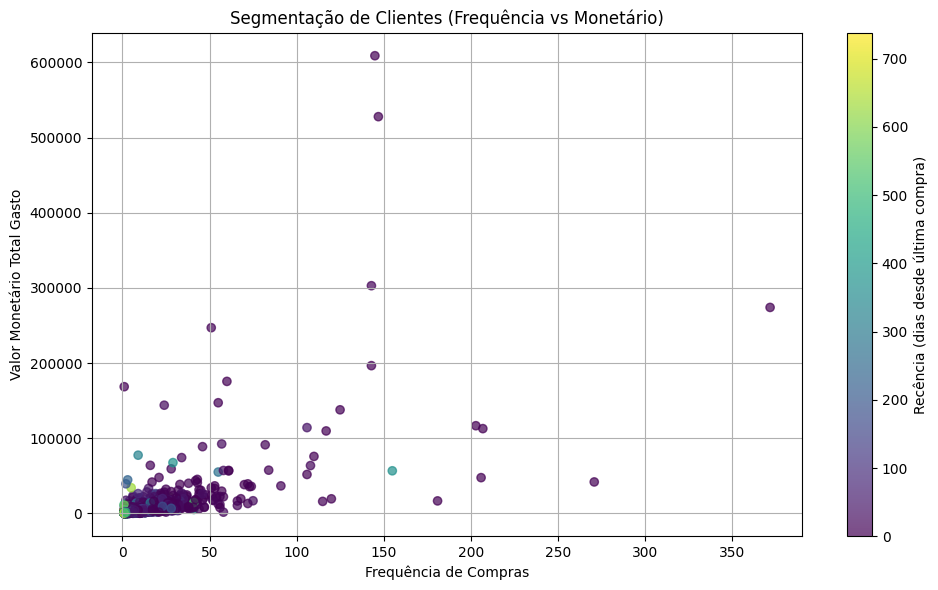

In [24]:
# Agrupa os dados por cliente
rfm = df_clientes.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (df['InvoiceDate'].max() - x.max()).days,  # Recência
    'Invoice': 'nunique',                                               # Frequência
    'Price': lambda x: (x * df_clientes.loc[x.index, 'Quantity']).sum() # Monetário
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Gráfico de dispersão: Frequência x Monetário
plt.figure(figsize=(10, 6))
scatter = plt.scatter(rfm['Frequency'], rfm['Monetary'], 
                      c=rfm['Recency'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Recência (dias desde última compra)')
plt.title('Segmentação de Clientes (Frequência vs Monetário)')
plt.xlabel('Frequência de Compras')
plt.ylabel('Valor Monetário Total Gasto')
plt.grid(True)
plt.tight_layout()
plt.show()


# Devoluções

Customer ID
12346.0   -74233
12349.0       -5
12352.0      -66
12359.0     -226
12360.0       -1
Name: Quantity, dtype: int64


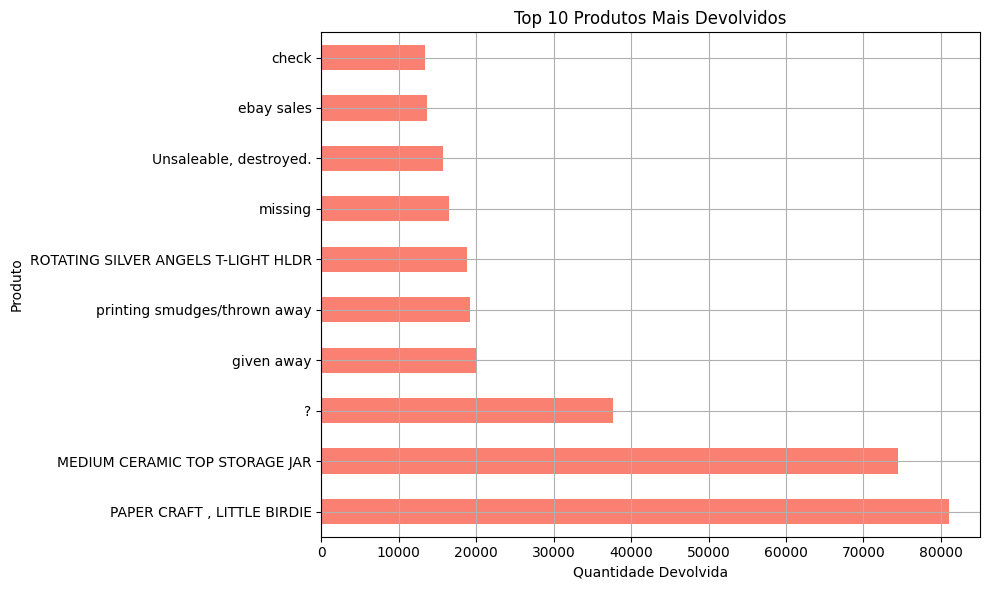

In [25]:
devolucoes_por_cliente = df_devolucoes.groupby('Customer ID')['Quantity'].sum()

print(devolucoes_por_cliente.head(5))

# Total de devoluções por produto
devolucoes_por_produto = df_devolucoes.groupby('Description')['Quantity'].sum().sort_values()

# Top 10 produtos mais devolvidos
top_devolvidos = devolucoes_por_produto.head(10).abs()

# Gráfico dos produtos mais devolvidos
plt.figure(figsize=(10, 6))
top_devolvidos.plot(kind='barh', color='salmon')
plt.title("Top 10 Produtos Mais Devolvidos")
plt.xlabel("Quantidade Devolvida")
plt.ylabel("Produto")
plt.tight_layout()
plt.grid(True)
plt.show()


C:\Users\nickm\AppData\Local\Temp\ipykernel_22212\253281140.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_devolucoes = df_devolucoes[df['Description'].notna() & df_devolucoes['Description'].str.isupper()]


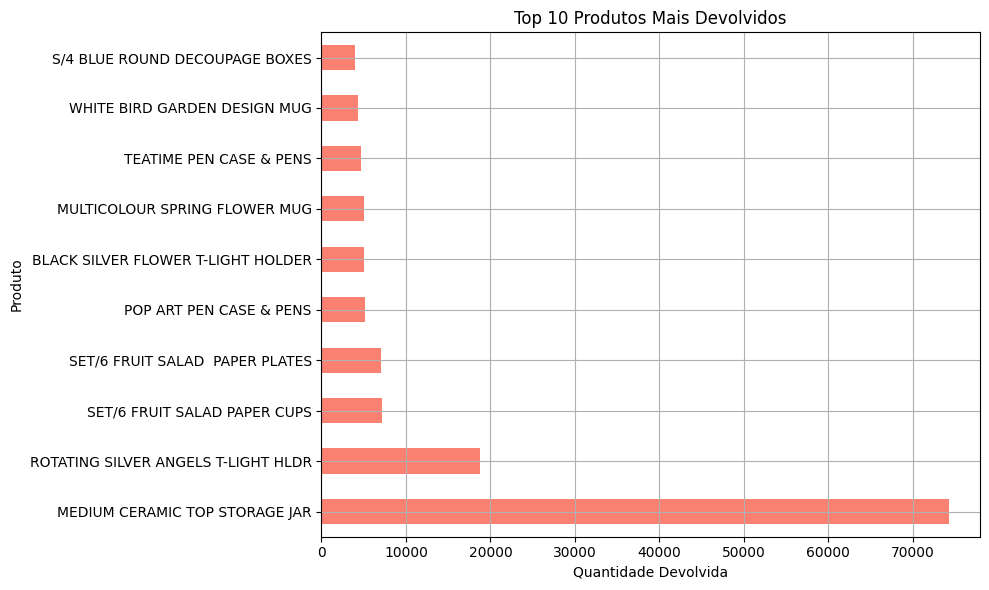

In [26]:
# Filtra apenas os produtos com a descrição toda em maiúsculo
df_devolucoes = df_devolucoes[df['Description'].notna() & df_devolucoes['Description'].str.isupper()]

devolucoes_por_cliente = df_devolucoes.groupby('Customer ID')['Quantity'].sum()

# Total de devoluções por produto
devolucoes_por_produto = df_devolucoes.groupby('Description')['Quantity'].sum().sort_values()

# Top 10 produtos mais devolvidos
top_devolvidos = devolucoes_por_produto.head(10).abs()

# Exibe resumo
# print(f"Total de registros de devoluções: {len(df_devolucoes)}")
# print(f"Clientes únicos com devoluções: {df_devolucoes['Customer ID'].nunique()}")
# print("\nTop 10 produtos mais devolvidos:")
# print(top_devolvidos)

# Gráfico dos produtos mais devolvidos
plt.figure(figsize=(10, 6))
top_devolvidos.plot(kind='barh', color='salmon')
# for i, val in enumerate(top_devolvidos):
#     plt.text(str(top_devolvidos.index[i]), val, str(int(val)), ha='right', va='bottom', fontsize=10, color='darkred')

plt.title("Top 10 Produtos Mais Devolvidos")
plt.xlabel("Quantidade Devolvida")
plt.ylabel("Produto")
plt.tight_layout()
plt.grid(True)
plt.show()


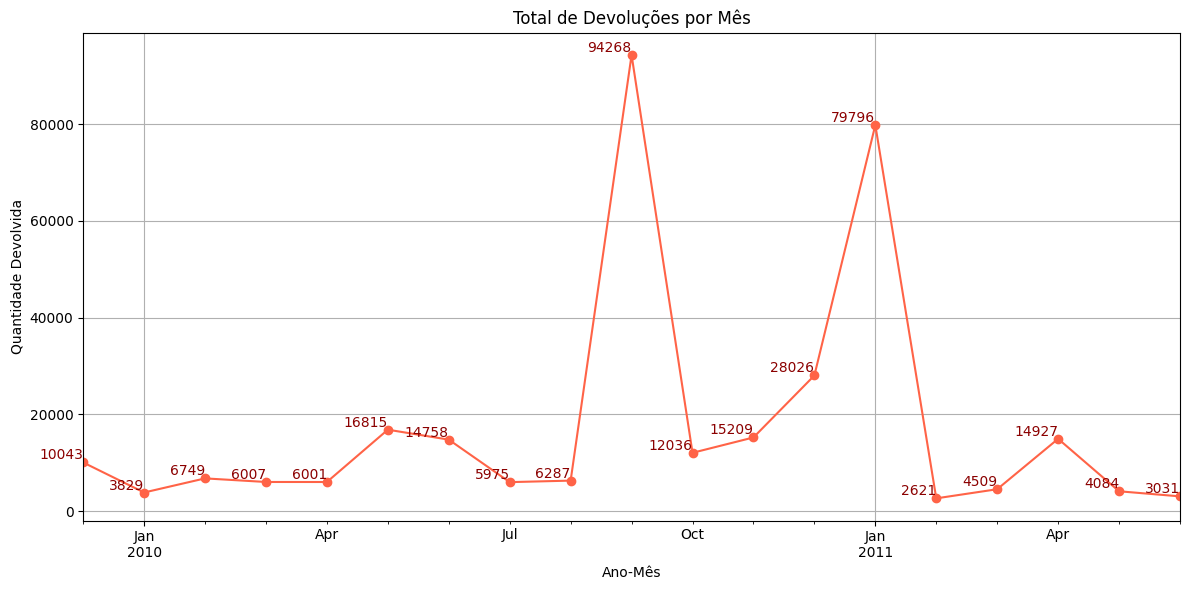

In [27]:
# Filtra devoluções (quantidade negativa)
# df_devolucoes = df[df['Quantity'] < 0].copy()

# Cria uma coluna de mês (ano-mês) para agrupamento
df_devolucoes['AnoMes'] = df_devolucoes['InvoiceDate'].dt.to_period('M')

# Agrupa por mês e soma as quantidades devolvidas
devolucoes_mensais = df_devolucoes.groupby('AnoMes')['Quantity'].sum().abs()

# Plota o gráfico de linha
plt.figure(figsize=(12, 6))
devolucoes_mensais.plot(marker='o', color='tomato')
for i, val in enumerate(devolucoes_mensais):
    plt.text(devolucoes_mensais.index[i], val, str(int(val)), ha='right', va='bottom', fontsize=10, color='darkred')
plt.title('Total de Devoluções por Mês')
plt.xlabel('Ano-Mês')
plt.ylabel('Quantidade Devolvida')
plt.grid(True)
plt.tight_layout()
plt.show()


# Produtos frequentemente comprados juntos

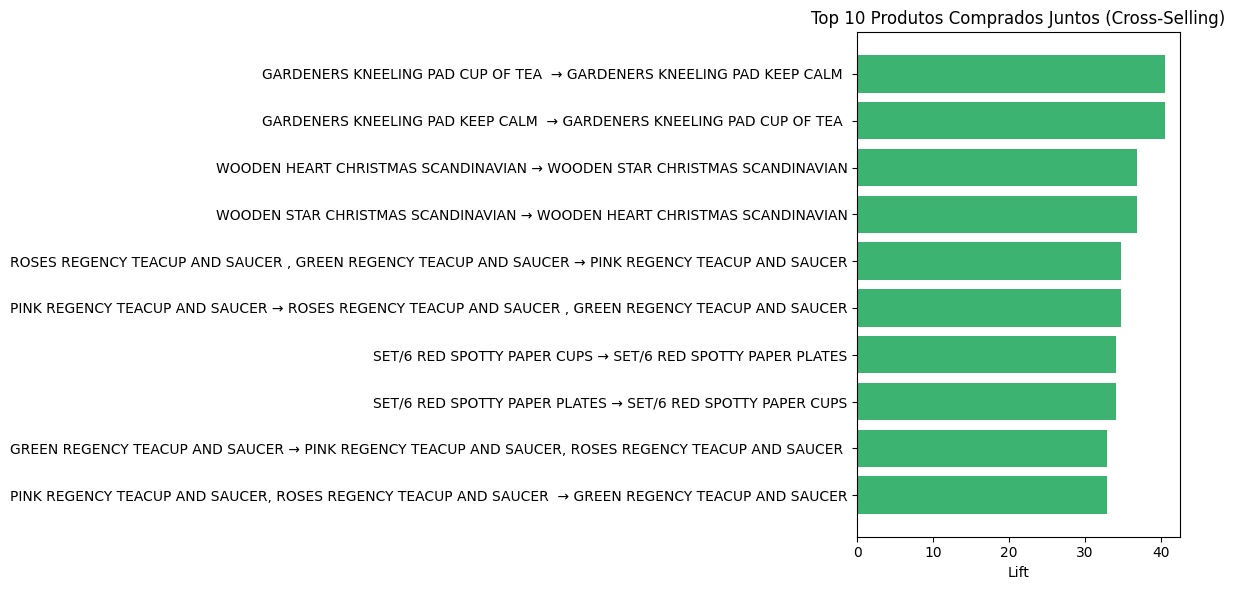

In [28]:
# Filtrar dados válidos
df_clean = df[(df['Quantity'] > 0) & df['Invoice'].notnull() & df['Description'].notnull()]

# Agrupa os produtos por Invoice (fatura)
basket = df_clean.groupby(['Invoice'])['Description'].apply(list)

# Converte para o formato one-hot (matriz de presença)
te = TransactionEncoder()
te_ary = te.fit(basket).transform(basket)
df_basket = pd.DataFrame(te_ary, columns=te.columns_)

# Aplica o algoritmo Apriori
frequent_itemsets = apriori(df_basket, min_support=0.01, use_colnames=True)

# Regras de associação
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Ordena pelas regras com maior lift
top_rules = rules.sort_values('lift', ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
pairs = top_rules.apply(lambda row: f"{', '.join(row['antecedents'])} → {', '.join(row['consequents'])}", axis=1)
plt.barh(pairs, top_rules['lift'], color='mediumseagreen')
plt.xlabel('Lift')
plt.title('Top 10 Produtos Comprados Juntos (Cross-Selling)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

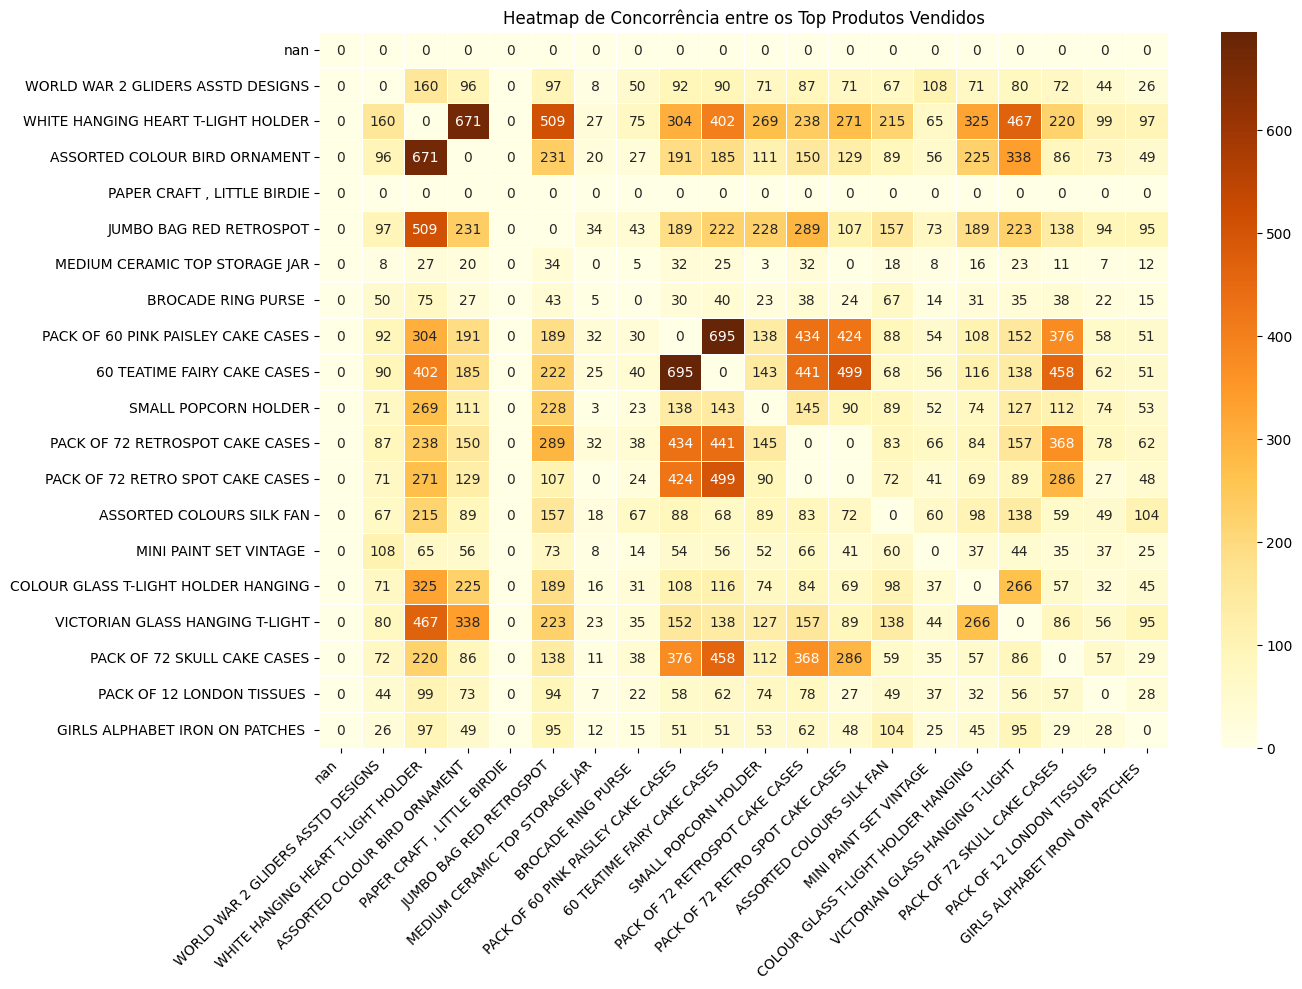

In [34]:
# Pega os produtos mais vendidos
top_n = 20
top_products = (
    df_clean.groupby('Description')['Quantity'].sum()
    .sort_values(ascending=False)
    .head(top_n)
    .index.tolist()
)

# Filtra apenas os dados com esses produtos
df_top = df_clean[df_clean['Description'].isin(top_products)]

# Agrupa por fatura: lista de produtos por invoice
basket_sets = df_top.groupby('Invoice')['Description'].apply(set)

# Contar coocorrências entre pares de produtos
pair_counts = Counter()
for products in basket_sets:
    for pair in combinations(products, 2):
        pair_counts[tuple(sorted(pair))] += 1

# Criar matriz de coocorrência
matrix = pd.DataFrame(index=top_products, columns=top_products).fillna(0)
for (prod1, prod2), count in pair_counts.items():
    matrix.loc[prod1, prod2] = count
    matrix.loc[prod2, prod1] = count

# Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(matrix, cmap="YlOrBr", annot=True, fmt='.0f', linewidths=.5)
plt.title("Heatmap de Concorrência entre os Top Produtos Vendidos")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Em desenvolviment

In [ ]:
# Tabela de recompra com checkmark
matriz_recompra = df.groupby(["Customer ID", "mes"]).size().unstack().fillna(0)
matriz_recompra = matriz_recompra.applymap(lambda x: "✓" if x > 0 else "")
print(matriz_recompra)

mes         1  2  3  4  5  6  7  8  9  10 11 12
Customer ID                                    
12346.0      ✓                                ✓
12347.0      ✓        ✓     ✓     ✓     ✓     ✓
12348.0      ✓        ✓              ✓        ✓
12349.0               ✓                 ✓  ✓   
12350.0         ✓                              
...         .. .. .. .. .. .. .. .. .. .. .. ..
18283.0      ✓  ✓  ✓  ✓  ✓  ✓  ✓  ✓  ✓  ✓  ✓  ✓
18284.0                                 ✓      
18285.0         ✓                              
18286.0                           ✓           ✓
18287.0                  ✓           ✓  ✓  ✓   

[5840 rows x 12 columns]


# TODO Futuras implementações

In [ ]:
# Coisas que podemos fazer
# Comparar datas da primeira compra até a compra mais recente
# df['rental_days'] = df[['rental_date', 'return_date']].apply(lambda x: (x[1] - x[0]).days, axis=1)
# Usar bokeh

In [ ]:
# from bokeh.plotting import figure, output_file, show
# from bokeh.io import output_notebook